In [1]:
import os
from collections import defaultdict
import time

import numpy as np 
import polars as pl 
import matplotlib.pyplot as plt
import torch 
from pytorch_tabnet.tab_model import TabNetRegressor

generator = torch.Generator().manual_seed(42)

for dirname, _, filenames in os.walk('../../../../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../../../data/test.csv
../../../../data/novozymes-enzyme-stability-prediction.zip
../../../../data/test_labels.csv
../../../../data/archive.zip
../../../../data/wildtype_structure_prediction_af2.pdb
../../../../data/train.csv
../../../../data/train_updates_20220929.csv
../../../../data/sample_submission.csv
../../../../data/aminoacids.csv


In [2]:
###############################################################################
## Load in training and test data. Update training data with updated version ##
###############################################################################
#Load training csv and updated training csv
data = pl.read_csv("../../../../data/train.csv")
data_updates = pl.read_csv("../../../../data/train_updates_20220929.csv")

data_updates = data_updates.filter(data_updates["tm"].is_not_null())


data = data.filter(~data["seq_id"].is_in(data_updates["seq_id"]))
data = pl.concat([data, data_updates])

# Remove rows with an undefined pH in the training set
data = data.filter(data["pH"].is_not_null())
data = data.drop("data_source")


In [3]:
pad_length = 0

# Add a column for sequence length 
data = data.with_columns(length=data["protein_sequence"].str.lengths())

# Keep only sequences within the 95 %ile in length
cutoff_length_max = int(data["length"].quantile(0.95))
cutoff_length_min = int(data["length"].quantile(0.05))
data = data.filter(data["length"] < cutoff_length_max)
data = data.filter(data["length"] > cutoff_length_min)

# Add a column for the Boltzmann inversion of Tm (provides a more normal 
# distribution)
data = data.with_columns(exp_tm=np.e ** (-1/data["tm"]))

# Add column for padded sequence
data = data.with_columns(padded_sequence=data["protein_sequence"].str.pad_end(cutoff_length_max, "X"))

/tmp/ipykernel_8058/4223619915.py:4: DeprecationWarning: `lengths` is deprecated. It has been renamed to `len_bytes`.
  data = data.with_columns(length=data["protein_sequence"].str.lengths())


In [4]:
# Get a list of the amino acids present in the dataset (note only the 20 
# standard are present here). 
amino_acid_list = list(sorted(
    {aa for sequence in data["protein_sequence"] for aa in set(sequence)}
))

###############################################################################
## Load amino acid data into                                                 ##
###############################################################################

amino_acid_data = pl.read_csv("../../../../data/aminoacids.csv")

# Drop string-based columns
amino_acid_data = amino_acid_data.drop(["Name", "Abbr", "Molecular Formula", 
                                        "Residue Formula"])
amino_acid_data = amino_acid_data.fill_null(float("nan"))

# Create entry for the "buffer residue" , which represents the pad residue
buffer_residue = {
    "Letter": "X",
    "Molecular Weight": 0,
    "Residue Weight": 0,
    "pKa1" : float("nan"),
    "pKb2" : float("nan"),
    "pKx3" : float("nan"),
    "pl4"  : float("nan"),
    "H" : 0,
    "VSC" : 0,
    "P1" : 0,
    "P2" : 0,
    "SASA" : 0,
    "NCISC" : 0,
    "carbon" : 0,
    "hydrogen" : 0,
    "nitrogen" : 0,
    "oxygen" : 0,
    "sulfur" : 0,
}

# Renumber and remove the index column, add the buffer residue to df
amino_acid_data = pl.concat([amino_acid_data, pl.DataFrame(buffer_residue)], how="vertical_relaxed")

print("Amino acid features:")
print(" | ".join(amino_acid_data.columns))

# Convert dataframe into a dictionary with the residue letter as the key
amino_acid_data_dictionary = {row[0]: np.array(row[1:], dtype=np.float32) 
                              for row 
                              in amino_acid_data.rows()}

Amino acid features:
Letter | Molecular Weight | Residue Weight | pKa1 | pKb2 | pKx3 | pl4 | H | VSC | P1 | P2 | SASA | NCISC | carbon | hydrogen | nitrogen | oxygen | sulfur


In [5]:
data_array = np.zeros((len(data), cutoff_length_max, len(amino_acid_data.columns) - 1), dtype=np.float32)

In [6]:
for seq_num, row_inputs in enumerate(zip(data["padded_sequence"], data["pH"])):
    sequence, pH = row_inputs
    row_encoded = np.zeros((cutoff_length_max, len(amino_acid_data.columns) - 1), dtype=np.float32)
    
    for res_num, amino_acid in enumerate(sequence):
        row_encoded[res_num] = amino_acid_data_dictionary[amino_acid]
    
    row_encoded[:, [2,3, 4,5]] = row_encoded[:, [2,3, 4,5]] - pH
    row_encoded[:, 3] = row_encoded[:, 3] - (14-pH)
    row_encoded[:, 2:6] = 10 ** (row_encoded[:, 2:6])
    row_encoded[:, 2:6] = 1 / (row_encoded[:, 2:6] + 1)
    row_encoded = np.nan_to_num(row_encoded, nan=1.0)
        
    data_array[seq_num] = row_encoded

In [7]:
train_idxs, test_idxs = torch.utils.data.random_split(range(data_array.shape[0]), [0.8, 0.2])
train_idxs, val_idxs = torch.utils.data.random_split(train_idxs, [0.8, 0.2])
train_array, test_array, val_array = data_array[train_idxs], data_array[test_idxs], data_array[val_idxs]
train_Y, test_Y, val_Y = data["tm"].to_numpy()[train_idxs], data["tm"].to_numpy()[test_idxs], data["tm"].to_numpy()[val_idxs]

del(data_array)
del(data)

train_len = train_array.shape[0]
val_len = val_array.shape[0]

n_chunks = 5
train_start = 0
val_start = 0
chunk_num = 0
"""
for train_end, val_end in zip(
    range(0, train_len, int(train_len/n_chunks)),
    range(0, val_len, int(val_len/n_chunks))):

    if chunk_num in (0, n_chunks):
        chunk_num += 1
        continue
    
    elif chunk_num == n_chunks-1:
        train_end = train_len
        val_end = val_len

    np.save(f"train_X_{chunk_num}.npy", train_array[train_start:train_end])
    np.save(f"val_X_{chunk_num}.npy", val_array[val_start:val_end])
    np.save(f"train_Y_{chunk_num}.npy", train_Y[train_start:train_end])
    np.save(f"val_Y_{chunk_num}.npy", val_Y[val_start:val_end])

    chunk_num += 1
    train_start = train_end
    val_start = val_end

"""

'\nfor train_end, val_end in zip(\n    range(0, train_len, int(train_len/n_chunks)),\n    range(0, val_len, int(val_len/n_chunks))):\n\n    if chunk_num in (0, n_chunks):\n        chunk_num += 1\n        continue\n    \n    elif chunk_num == n_chunks-1:\n        train_end = train_len\n        val_end = val_len\n\n    np.save(f"train_X_{chunk_num}.npy", train_array[train_start:train_end])\n    np.save(f"val_X_{chunk_num}.npy", val_array[val_start:val_end])\n    np.save(f"train_Y_{chunk_num}.npy", train_Y[train_start:train_end])\n    np.save(f"val_Y_{chunk_num}.npy", val_Y[val_start:val_end])\n\n    chunk_num += 1\n    train_start = train_end\n    val_start = val_end\n\n'

In [8]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model("./tabnet_model_test_1.zip")

/home/parashara/micromamba/envs/novozymes/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Spearman R:  0.430079206652215


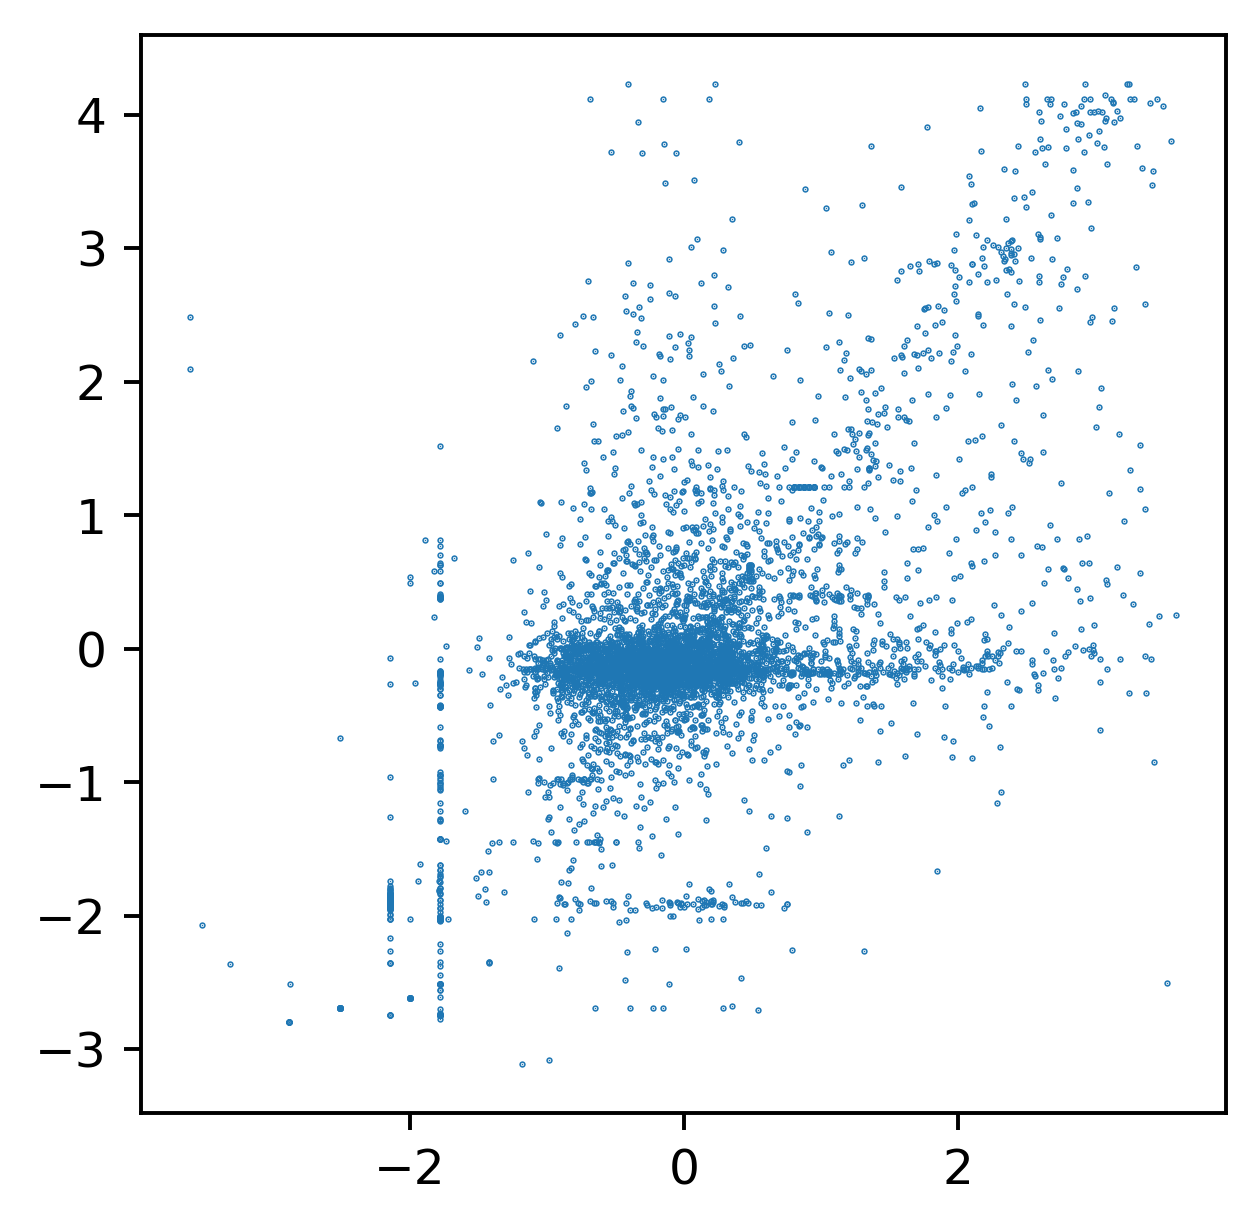

In [9]:
import scipy
import sklearn
import matplotlib.pyplot as plt

pred_Y = loaded_clf.predict(test_array.reshape(test_array.shape[0], -1))
print("Spearman R: ", scipy.stats.spearmanr(test_Y, pred_Y).statistic)

plt.figure(dpi=350, figsize=(4, 4))
plt.scatter(scipy.stats.zscore(test_Y.reshape(-1, 1)), 
            scipy.stats.zscore(pred_Y.reshape(-1, 1)), s=0.1)

In [10]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model("./tabnet_model_test_2.zip")

Spearman R:  0.47215249098680595


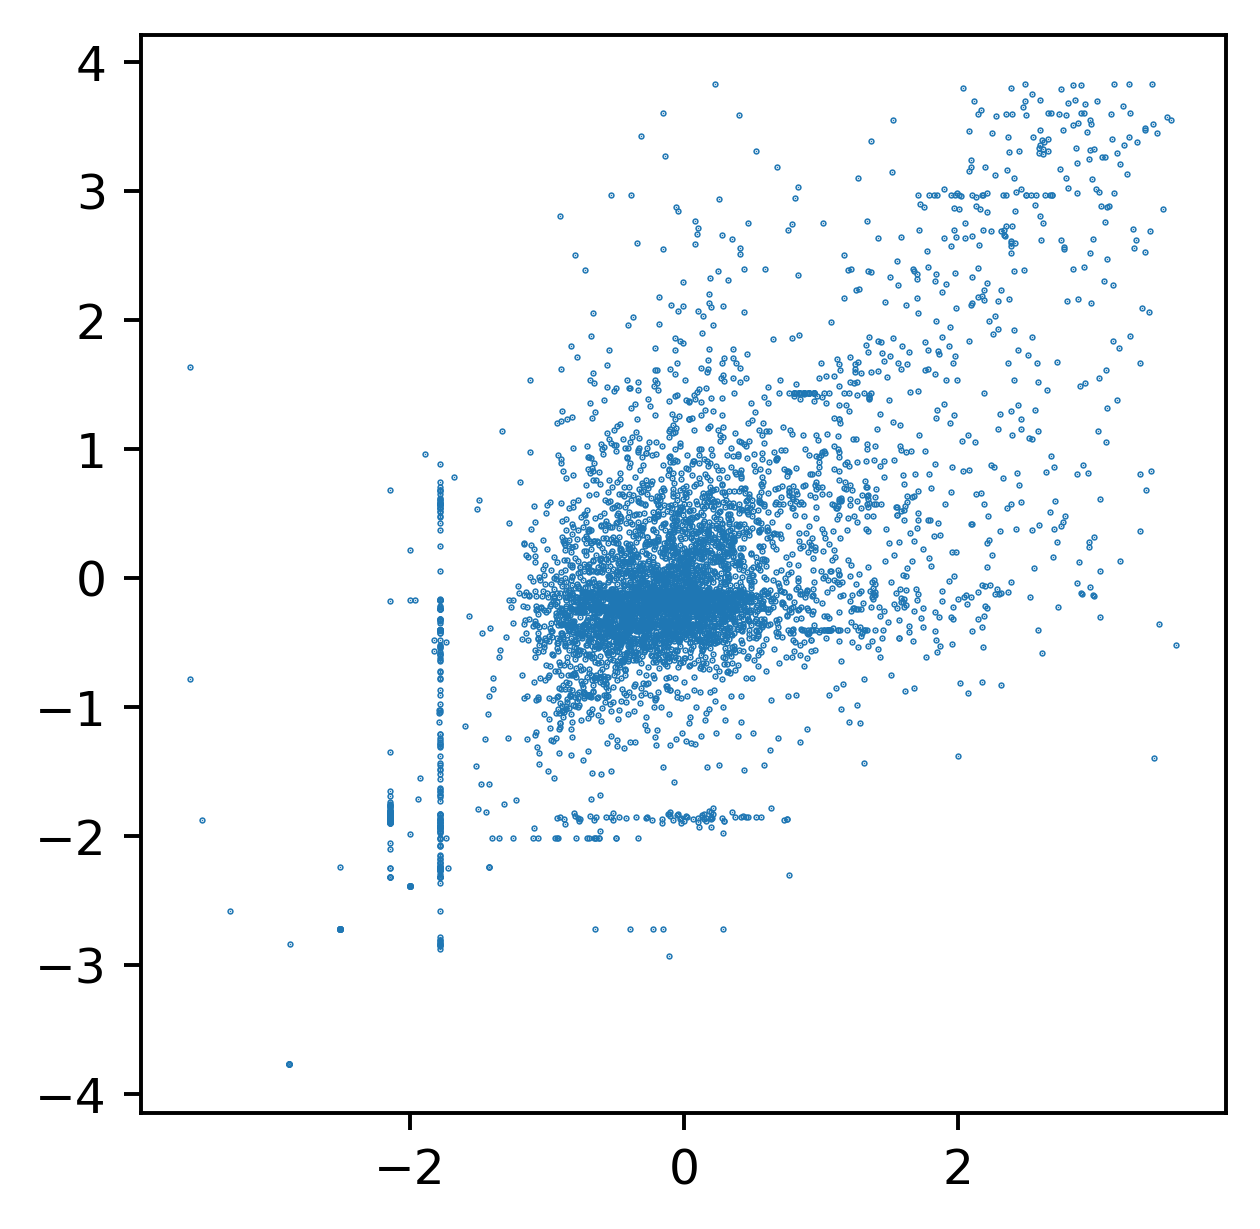

In [11]:
import scipy
import sklearn
import matplotlib.pyplot as plt

pred_Y = loaded_clf.predict(test_array.reshape(test_array.shape[0], -1))
print("Spearman R: ", scipy.stats.spearmanr(test_Y, pred_Y).statistic)

plt.figure(dpi=350, figsize=(4, 4))
plt.scatter(scipy.stats.zscore(test_Y.reshape(-1, 1)), 
            scipy.stats.zscore(pred_Y.reshape(-1, 1)), s=0.1)